In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

We hypothesize that option open interest data contains information that could help predict future price. Thus we seek for the relation between the open interest change and the return in the next week in this passage. There are put open interest and call open interest, which serve oppisite function in foreshadowing the future price. And we are also going to consider the put-call ratio which is the ratio of put open interest to the call open interest.

In [2]:
sys.path.insert(0, r'C:\Users\xuanh\Documents\hx')
from functions_cache import *

## Daily Information of Future M

In [3]:
# 豆粕
symbol = 'M'

In [4]:
opt_path = r'C:\Users\xuanh\Documents\hx\opition_data\option_data_'
begin_date = '2017-3-31'
end_date = '2019-12-6'

In [5]:
cont_list_path = r'C:\Users\xuanh\Documents\hx\opition_data\contract_list'     # dominant contract for each trading day
trading_contract_filename = symbol + '_trading_contract.csv'
cont_list_df = pd.read_csv(cont_list_path + '/' + trading_contract_filename, index_col='Trading_Day', parse_dates=True)
cont_list_df = cont_list_df.shift(1).dropna()
cont_list_df = cont_list_df[begin_date:end_date]
cont_list_df.columns = ['contract']

In [6]:
# adjusted future prices are used for calculating the return
adjusted_future_prices_path = r'D:\cta_daily\data\processed\adjusted_continuous_data\close'   # corresponding future price for each trading day
close_filename = symbol + '_close.csv'
adjusted_future_prices_df = pd.read_csv(adjusted_future_prices_path + '/' + close_filename, index_col='Trading_Day', parse_dates=True)
adjusted_future_prices_df = adjusted_future_prices_df[begin_date:end_date]
adjusted_future_prices_df.columns = ['adjusted_future_price']

In [7]:
# raw future prices are used for dividing contracts into in-the-money and out-of-the-money
future_prices_path = r'D:\cta_daily\data\processed\continuous_data\close'
future_prices_df = pd.read_csv(future_prices_path + '/' + close_filename, index_col='Trading_Day', parse_dates=True)
future_prices_df = future_prices_df[begin_date:end_date]
future_prices_df.columns = ['future_price']

In [8]:
columns = ['call_interest', 'put_interest']
daily_df = pd.concat([cont_list_df, adjusted_future_prices_df, future_prices_df], axis=1)
add_new_columns(daily_df, columns)

In [9]:
daily_df.head()

,contract,adjusted_future_price,future_price,call_interest,put_interest
Trading_Day,,,,,
2017-03-31,M1709,2438.246816,2780.0,NaN,NaN
2017-04-05,M1709,2416.320136,2755.0,NaN,NaN
2017-04-06,M1709,2415.443069,2754.0,NaN,NaN
2017-04-07,M1709,2393.516389,2729.0,NaN,NaN
2017-04-10,M1709,2422.459607,2762.0,NaN,NaN


## Open Interest

In [10]:
# filter trading data whose volume is smaller than the minimun volume
# here no volume bounding is assigned
min_volume = 0

In the first loop, we consider each trading day separately and calculate the average open interest over all strike prices. For each trading day, [last contract] is the dominant contract nest day while [contract] is the dominant contract today. Initial values of them are None.

However, we have to collect extra information when dominant contract shifts from the old one to new one, since when calculating open interest change, contract should not change during the regarding period.

In [11]:
column_name = ['open_interest_call', 'premium_call', 'open_interest_put', 'premium_put']

In [12]:
%%time

daily_inf_idx = pd.MultiIndex(levels=[[],[]], labels=[[],[]], names=['trading_day', 'strike_price'])
daily_inf = pd.DataFrame(index=daily_inf_idx, columns=column_name)

last_contract, contract = None, None
count = 0

# [shift_contract] store the extra information when dominant contract shifts
shift_contract = pd.DataFrame(columns=columns) 

daily_int_list = []

for idx in daily_df.index:  # consider each trading day separately

    contract = daily_df['contract'][idx]  # find the dominant contract
    contract = contract[len(symbol):]

    if last_contract == contract:
        contract_change = False
    else:
        contract_change = True

    if contract_change:  # if dominant contract changes, update dataframes
        # list of strike prices of the dominant contract 
        strike_prices = get_strike_prices(opt_path, symbol, contract)
        # list of dataframes with different option prices. Put and call options are considered separately
        dfs_call, dfs_put = get_put_call_information(strike_prices, opt_path, symbol, contract)
        strike_prices_int = [int(price) for price in strike_prices]
        

    # [open interest] dataframe stores imformation at each day 
    # the information includes premiums and open interest of both put and call option
    open_interest = np.full([len(strike_prices), len(column_name)], np.nan)

    # if contract shifts, then yesterday data of the new contract is stored in [open_interest_yesterday] dataframe
    open_interest_yesterday = np.full([len(strike_prices), len(column_name)], np.nan)


    for i in range(len(strike_prices)):

        # get open interest values from [dfs_call] and [dfs_put]
        open_interest[i][0], open_interest[i][1] = get_values(idx, dfs_call[i], min_volume, ['open_interest', 'close'])
        open_interest[i][2], open_interest[i][3] = get_values(idx, dfs_put[i], min_volume, ['open_interest', 'close'])

        price = strike_prices[i]
        
        int_list = [idx, int(price)] + list(open_interest[i])
        daily_int_list.append(int_list)
        #daily_inf.loc[(idx, price), :] = open_interest[i]
            
        if contract_change and count > 0:
            # if contract shifts, get yeseterday open interest
            yesterday_idx = daily_df[:idx].index[-2]
            open_interest_yesterday[i][0], open_interest_yesterday[i][1] = get_values(yesterday_idx, dfs_call[i], 
                                                                                      min_volume, ['open_interest', 'close'])
            open_interest_yesterday[i][2], open_interest_yesterday[i][3] = get_values(yesterday_idx, dfs_put[i], 
                                                                                      min_volume, ['open_interest', 'close'])

    # in the above, data are arranged separately for contracts with different strike prices
        # below we are going to take average over all strike prices thus output single-row data of each trading day 
    open_interest = open_interest[~np.isnan(open_interest).any(axis=1)]

    
    # compute average open interest
    daily_df.loc[idx, 'call_interest'] = open_interest.mean(axis=0)[0]
    daily_df.loc[idx, 'put_interest'] = open_interest.mean(axis=0)[2]

    # if contract changes, add information in [shift_contract]
    if contract_change and count > 0:

        open_interest_yesterday = open_interest_yesterday[~np.isnan(open_interest_yesterday).any(axis=1)]

        yesterday_interest = pd.DataFrame(None, index=[yesterday_idx], columns=columns)

        yesterday_interest['call_interest'] = open_interest_yesterday.mean(axis=0)[0]
        yesterday_interest['put_interest'] = open_interest_yesterday.mean(axis=0)[2]


        shift_contract = pd.concat([shift_contract, yesterday_interest], axis=0)

    last_contract = contract
    count += 1
    if (count == 1000):
        break

Wall time: 1.3 s


In [13]:
daily_int_df = pd.DataFrame.from_records(daily_int_list)
daily_int_df.columns = ['trading_day', 'strike_price'] + column_name

In [14]:
daily_int_df = daily_int_df.set_index(['trading_day', 'strike_price'])

In [15]:
#daily_int_df.to_csv(opt_path + '/daily_interest.csv')

In [16]:
daily_int_df

open_interest_call  premium_call  open_interest_put  \
trading_day strike_price                                                        
2017-03-31  2400                         NaN           NaN                NaN   
            2450                         NaN           NaN                NaN   
            2500                         NaN           NaN                NaN   
            2550                       376.0         255.5             1740.0   
            2600                       242.0         221.5             2768.0   
            2650                       126.0         185.5              496.0   
            2700                        94.0         154.5              418.0   
            2750                       296.0         129.0              712.0   
            2800                      1100.0         106.5              998.0   
            2850                      1040.0          84.0              150.0   
            2900                       558.0          68.0               62.0   
            2950                       738.0          53.5              160.0   
            3000                      2880.0          42.0              298.0   
            3050                         NaN           NaN                NaN   
            3100                         NaN           NaN                NaN   
            3150                         NaN           NaN                NaN   
2017-04-05  2400                         NaN           NaN                NaN   
            2450                         NaN           NaN                NaN   
            2500                         NaN           NaN                NaN   
            2550                      1232.0         233.5             1954.0   
            2600                       600.0         193.5             3250.0   
            2650                       352.0         158.5              734.0   
            2700                       114.0         130.5              756.0   
            2750                       470.0         107.5              580.0   
            2800                      1404.0          86.0             1080.0   
            2850                      1368.0          68.0              184.0   
            2900                      1754.0          54.0              164.0   
            2950                      1346.0          41.5              362.0   
            3000                      3674.0          31.5              534.0   
            3050                         NaN           NaN                NaN   
...                                      ...           ...                ...   
2019-03-06  2850                     16282.0           4.5             1586.0   
            2900                     17838.0           3.0             3944.0   
            2950                      6766.0           2.5              712.0   
            3000                     12498.0           2.5              746.0   
            3050                      5354.0           2.0              448.0   
            3100                      6004.0           1.5              720.0   
            3150                     15528.0           1.5              540.0   
            3200                     13936.0           1.5             1316.0   
            3250                     24474.0           1.0              980.0   
2019-03-07  2250                       150.0         279.0             3466.0   
            2300                       532.0         232.0            11338.0   
            2350                       858.0         182.0             9892.0   
            2400                      1572.0         141.5            22452.0   
            2450                      2572.0          99.5            18180.0   
            2500                     14950.0          64.5            25066.0   
            2550                     21528.0          39.0            11952.0   
            2600                     28468.0          23.

## Put-to-call ratio

In [17]:
daily_df['put_call_ratio'] = daily_df['put_interest'] / daily_df['call_interest']
daily_df['return'] = daily_df['adjusted_future_price'].pct_change()

In [18]:
daily_df.loc[:, 'put_call_ratio':].describe()

,put_call_ratio,return
count,471.000000,470.000000
mean,0.817115,0.000133
std,0.212957,0.010871
min,0.524991,-0.047546
25%,0.634146,-0.005187
50%,0.789221,0.000000
75%,0.978952,0.005407
max,1.771285,0.047081


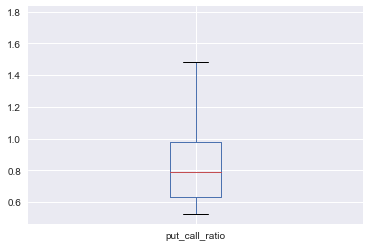

In [19]:
daily_df['put_call_ratio'].plot.box()

## Contract shift adjustment

However, daily changes are wrongly calculated when contract shifts. Thus we need to use data in [shift_contract] to update records in those days.

In [20]:
shift_contract['put_call_ratio'] = shift_contract['put_interest'] / shift_contract['call_interest']

In [21]:
# find dates when contract shifts
shift_contract

,call_interest,put_interest,put_call_ratio
2017-07-26,2871.875000,2142.875000,0.746159
2017-11-22,5322.933333,4322.666667,0.812084
2018-03-15,3925.100000,4038.300000,1.028840
2018-07-02,2342.333333,2687.250000,1.147253
2018-11-27,5781.875000,5774.375000,0.998703


In [67]:
a.mean(axis=0)

array([nan,  1.,  1.,  1.])

In [22]:
columns.append('put_call_ratio')

In [23]:
# calculate changes of put interest, call interest and put-to-call ratio
daily_change_df = cal_diff(daily_df, columns)

In [24]:
# correct the change value when contract shifts
for day in shift_contract.index:
    next_day = daily_change_df[day:].index[1]
    daily_change_df.loc[next_day, columns] = (daily_df.loc[next_day, columns] - shift_contract.loc[day]).values

In [25]:
daily_change_df['adjusted_future_price'] = daily_df['adjusted_future_price']
daily_change_df['return'] = daily_df['return']

## Data display

In [26]:
daily_df

,contract,adjusted_future_price,future_price,call_interest,put_interest,put_call_ratio,return
Trading_Day,,,,,,,
2017-03-31,M1709,2438.246816,2780.0,745.000000,780.200000,1.047248,NaN
2017-04-05,M1709,2416.320136,2755.0,1231.400000,959.800000,0.779438,-0.008993
2017-04-06,M1709,2415.443069,2754.0,1334.909091,1046.181818,0.783710,-0.000363
2017-04-07,M1709,2393.516389,2729.0,1502.909091,1284.909091,0.854948,-0.009078
2017-04-10,M1709,2422.459607,2762.0,1748.545455,1512.363636,0.864927,0.012092
2017-04-11,M1709,2422.459607,2762.0,1892.727273,1669.454545,0.882037,0.000000
2017-04-12,M1709,2440.878018,2783.0,2038.727273,1709.272727,0.838402,0.007603
2017-04-13,M1709,2487.362580,2836.0,2075.818182,1834.909091,0.883945,0.019044
2017-04-14,M1709,2482.100176,2830.0,2159.833333,1771.166667,0.820048,-0.002116


In [27]:
daily_change_df

,call_interest,put_interest,put_call_ratio,adjusted_future_price,return
Trading_Day,,,,,
2017-03-31,NaN,NaN,NaN,2438.246816,NaN
2017-04-05,486.400000,179.600000,-0.267810,2416.320136,-0.008993
2017-04-06,103.509091,86.381818,0.004272,2415.443069,-0.000363
2017-04-07,168.000000,238.727273,0.071238,2393.516389,-0.009078
2017-04-10,245.636364,227.454545,0.009979,2422.459607,0.012092
2017-04-11,144.181818,157.090909,0.017110,2422.459607,0.000000
2017-04-12,146.000000,39.818182,-0.043635,2440.878018,0.007603
2017-04-13,37.090909,125.636364,0.045543,2487.362580,0.019044
2017-04-14,84.015152,-63.742424,-0.063897,2482.100176,-0.002116


## Strategy return

In [28]:
mom_lookback = 7
skip_recent = 0
holding_days = 1
slippage_percent = 0.0005

In [29]:
signal, diff_lookback = time_series_mom_signal(daily_change_df['put_call_ratio'], mom_lookback, skip_recent)

# price_change of the day is the change of price when opening the position right before close at that day
daily_change_df['price_change'] = daily_change_df['adjusted_future_price'].pct_change(holding_days).shift(-holding_days)

# signal return of the day is the return when opening the position right before close at that day
daily_change_df['signal_return'] = signal * (daily_change_df['price_change']) - slippage(signal, slippage_percent)

ret = daily_change_df.dropna()['signal_return']


In [30]:
plt.rcParams['figure.figsize'] = [10, 5]

0.723 0.125 0.172 0.123 0.712 0.145 0.685


(0.12475347083521648, 0.17243332761104743, 0.7234881595315441)

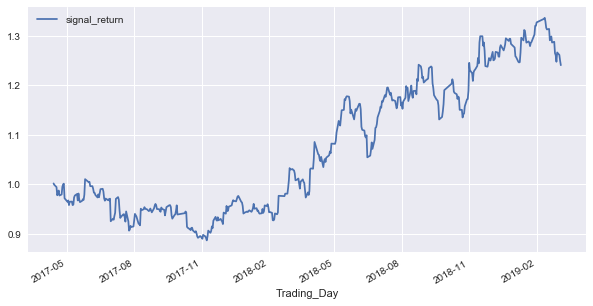

In [31]:
grading_(ret, False)

## Holding days > 1

In [32]:
holding_days = 5
shift_day = 1

In [33]:
signal_df = pd.DataFrame(None, index=range(len(signal)), columns=['Trading_day', 'signal', 'position'])
signal_df['Trading_day'] = signal.index
signal_df['signal'] = signal.values
signal_df = signal_df.shift(-shift_day).dropna(axis=0, how='all')

In [34]:
signal_df.loc[signal_df.index%holding_days == 0, 'position'] = signal_df.loc[signal_df.index%holding_days == 0, 'signal']
signal_df = signal_df.fillna(method='ffill')

In [35]:
position = pd.DataFrame(signal_df['position'].values, index=signal_df['Trading_day'])

In [36]:
position

,0
Trading_day,
2017-04-14,1.0
2017-04-17,1.0
2017-04-18,1.0
2017-04-19,1.0
2017-04-20,1.0
2017-04-21,-1.0
2017-04-24,-1.0
2017-04-25,-1.0
2017-04-26,-1.0


## Parameter test

In [37]:
def cal_return(daily_change_df, mom_lookback, skip_recent, holding_days, slippage_percent):
    
    signal,_ = time_series_mom_signal(daily_change_df['put_call_ratio'], mom_lookback, skip_recent)
    price_change = daily_change_df['adjusted_future_price'].pct_change().shift(-1)
    
    position_return_list = []
    for shift_day in range(holding_days):
        position = get_position(signal, holding_days, shift_day)
        postion_return = (position * price_change).dropna()
        slippage_adjusted_postion_return = postion_return - slippage(position, slippage_percent)
        slippage_adjusted_postion_return.name=str(mom_lookback)+'_'+str(skip_recent)+'_'+str(holding_days)+'_'+str(shift_day)
        position_return_list.append(slippage_adjusted_postion_return.dropna())
    
    return position_return_list

In [38]:
%%time
cal_return(daily_change_df, 7, 0, 1, slippage_percent)

Wall time: 2.99 ms


[Trading_Day
 2017-04-13    0.001616
 2017-04-14   -0.002767
 2017-04-17   -0.004602
 2017-04-18   -0.016647
 2017-04-19    0.004202
 2017-04-20    0.005626
 2017-04-21   -0.010255
 2017-04-24    0.002100
 2017-04-25    0.015784
 2017-04-26    0.004989
 2017-04-27    0.001507
 2017-04-28   -0.029582
 2017-05-02   -0.007252
 2017-05-03    0.002796
 2017-05-04   -0.009759
 2017-05-05    0.007096
 2017-05-08    0.000355
 2017-05-09   -0.007455
 2017-05-10    0.001057
 2017-05-11    0.015168
 2017-05-12    0.003940
 2017-05-15    0.003236
 2017-05-16   -0.013348
 2017-05-17    0.014596
 2017-05-18   -0.012199
 2017-05-19   -0.005750
 2017-05-22    0.002909
 2017-05-23    0.003282
 2017-05-24   -0.001366
 2017-05-25    0.010713
                 ...   
 2019-01-17   -0.008668
 2019-01-18   -0.009766
 2019-01-21    0.001934
 2019-01-22   -0.001938
 2019-01-23   -0.005416
 2019-01-24    0.005002
 2019-01-25    0.001547
 2019-01-28    0.008521
 2019-01-29    0.003125
 2019-01-30    0.013498
 20

In [39]:
%load_ext line_profiler

In [40]:
%lprun -f cal_return cal_return(daily_change_df, mom_lookback, skip_recent, 5, slippage_percent)

In [41]:
%lprun -f slippage slippage(position, slippage_percent)

In [42]:
%lprun -f get_position get_position(signal, holding_days, shift_day)

In [43]:
skip_recent = 0
holding_days = 3

In [44]:
mom_lookback = 5

In [45]:
mom_rets_lookback_list = cal_return(daily_change_df, mom_lookback, skip_recent, holding_days, slippage_percent)

0.743 0.129 0.173 0.194 1.123 0.148 0.704
1.103 0.190 0.172 0.113 0.657 0.207 1.020
0.602 0.104 0.173 0.121 0.699 0.124 0.575


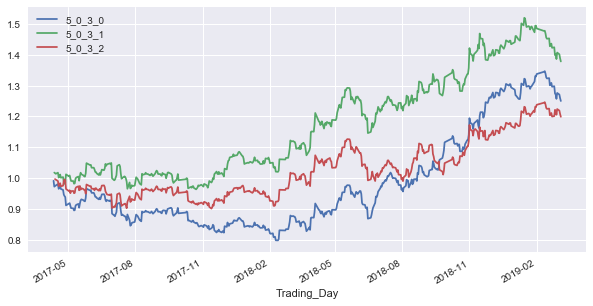

In [46]:
for mom_rets_lookback in mom_rets_lookback_list:
    grading_(mom_rets_lookback, False)

In [47]:
def highlight_value_smaller_than_(s, a):
    return 'background-color: white' if s<=a else ''

In [48]:
mom_lookback_list = [1, 2, 3, 4, 5, 6, 7, 8]
skip_recent_list = [0, 1, 2, 3]
holding_days_list = [1, 2, 3, 4, 5]

In [49]:
%%time
multiindex = pd.MultiIndex.from_product([skip_recent_list, holding_days_list])
return_df = pd.DataFrame(index=daily_change_df.index)

sharpe_ratio_df = pd.DataFrame(0.0, index=multiindex, columns=mom_lookback_list)
sharpe_ratio_df.index.names = ['skip_recent', 'holding_days']
sharpe_ratio_df.columns.name = 'mom_lookback'

annual_return_df = pd.DataFrame(0.0, index=multiindex, columns=mom_lookback_list)
annual_return_df.index.names = ['skip_recent', 'holding_days']
annual_return_df.columns.name = 'mom_lookback'

annual_vol_df = pd.DataFrame(0.0, index=multiindex, columns=mom_lookback_list)
annual_vol_df.index.names = ['skip_recent', 'holding_days']
annual_vol_df.columns.name = 'mom_lookback'

for mom_lookback in mom_lookback_list:
    for holding_days in holding_days_list:
        for skip_recent in skip_recent_list:
            sharpe_ratio_list = []
            annual_return_list = []
            annual_vol_list = []
            mom_rets = cal_return(daily_change_df, mom_lookback, skip_recent, holding_days, slippage_percent)
            return_shift = pd.DataFrame(0, index=daily_change_df.index, columns=range(len(mom_rets)))
            for i in range(len(mom_rets)):
                mom_ret = mom_rets[i]
                grading_result = grading(mom_ret, False)
                sharpe_ratio_list.append(grading_result[2])
                annual_return_list.append(grading_result[0])
                annual_vol_list.append(grading_result[1])
                return_shift[i] = mom_ret
            return_column = return_shift.mean(axis=1)
            return_df[str(mom_lookback) + '_' + str(holding_days) + '_' + str(skip_recent)] = return_column
            sharpe_ratio_df.loc[skip_recent, holding_days][mom_lookback] = np.mean(sharpe_ratio_list)
            annual_return_df.loc[skip_recent, holding_days][mom_lookback] = np.mean(annual_return_list)
            annual_vol_df.loc[skip_recent, holding_days][mom_lookback] = np.mean(annual_vol_list)

Wall time: 1.4 s


In [50]:
sharpe_ratio_df.to_csv(r'C:\Users\xuanh\Documents\hx\sharpe_ratio.csv')
annual_return_df.to_csv(r'C:\Users\xuanh\Documents\hx\annual_return.csv')
annual_vol_df.to_csv(r'C:\Users\xuanh\Documents\hx\annual_vol.csv')

In [57]:
s = annual_return_df.style.apply(background_gradient, cmin=0, cmax=annual_return_df.max().max()*2, axis=None).\
                        applymap(lambda x: highlight_value_smaller_than_(x, 0))
s

In [52]:
annual_vol_df.max().max()

0.1734686179033175

In [59]:
s = annual_vol_df.style.apply(background_gradient, cmin=0, cmax=annual_vol_df.max().max(), axis=None).\
                        applymap(lambda x: highlight_value_smaller_than_(x, 0))
s

In [60]:
# compare different holding days

s = sharpe_ratio_df.style.apply(background_gradient, cmin=0, cmax=sharpe_ratio_df.max().max()*2, axis=None).\
                        applymap(lambda x: highlight_value_smaller_than_(x, 0))
s

In [ ]:
len(mom_rets)

In [ ]:
return_df.to_csv('return_df.csv')

In [ ]:
return_df